In [8]:
# adds parent dir to python path
import sys
sys.path.insert(0, '..')

#system lib
import os

# 3rd party lib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

# astro lib
from astropy.io import fits
import sep

# my lib
import ImageTools as it
import DataTools as dt

In [6]:
def make_nonnegative(img):
    epsilon = 0 if len(img[img<0])==0 else img[img>0].min()
    return img + abs(img.min()) + epsilon

def get_random_spheroids(num=10):
    with open('../spheroids', 'r') as f:
        spheroids = np.array(f.readlines())
    
    if num==-1:
        num = len(spheroids)
    
    selected = np.random.choice(spheroids, num, replace=False)
    
    data_dir = os.path.join(os.getenv('HOME'), 'Documents/astro_data/orig_images')
    fmask = 'GDS_{}_{}.fits'
    f_string = os.path.join(data_dir, fmask)

    sources = []
    for s in selected:
        img = fits.getdata(f_string.format(s.strip(), 'h'))
        segmap = fits.getdata(f_string.format(s.strip(), 'segmap'))
        img_id = int(s.split('_')[1])
        sources.append((img.copy(), segmap.copy(), img_id))
        del img 
        del segmap
    
    return sources

# Petrosian Helpers ----------------------------------------------------------
def one_over_eta(rs, fs, R):
    return ((np.pi*R**2) / (np.sum(fs[rs<=R]))) * fs[rs==R]

def petrosian_radius(rs, fs):
    #r_candidates = np.array([one_over_eta(rs, fs, R) for R in rs])
    r_candidates = np.array([fs[rs==r]/fs[rs<=r].mean() for r in rs]).flatten()
    
    return rs[np.square(r_candidates-0.2).argmin()]

def petrosian_flux(rs, fs, R_p):
    return np.sum(fs[rs<=2*R_p])

def R_x(rs, fs, x):
    x /= 100
    sum_ratio = np.cumsum(fs)/np.sum(fs)
    return rs[np.square(sum_ratio-x).argmin()]

def petrosian_Re(R_50, R_90):
    P_3 = 8e-6
    P_4 = 8.47
    return R_50 / (1 - P_3*(R_90/R_50)**P_4)

def get_rs_and_fs(img, src_map):
    cx, cy = it.img_center(img, src_map)
    xs, ys = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]).T)
    rs = np.sqrt(np.square(xs-cx)+np.square(ys-cy))
    
    rs = rs.flatten()
    fs = img.flatten()
    sorted_rs = np.argsort(rs)
    
    rs = rs[sorted_rs]
    fs = fs[sorted_rs]
    
    #fs = dt.loessc(rs, fs, 10)
    
    return rs, fs

def get_re(img, src_map):
    rs, fs = get_rs_and_fs(img, src_map)
    
    R_p = petrosian_radius(rs, fs)
    F_p = petrosian_flux(rs, fs, R_p)
    p_mask = rs <= 2*R_p
    
    _rs = rs[p_mask]
    _fs = fs[p_mask]

    R_50 = R_x(_rs, _fs, 50)
    R_90 = R_x(_rs, _fs, 90)

    re = petrosian_Re(R_50, R_90)
    re_idx = np.square(_rs-re).argmin()
    
    return rs[re_idx], rs, fs
# Petrosian Helpers ----------------------------------------------------------

def denoise(img, segmap, img_id):
    noise_bank = img[segmap==0].flatten()
    other_source = np.logical_and(segmap!=0, segmap!=img_id)
    np.place(img, other_source, noise_bank)
    
    array_sep_likes = img.byteswap().newbyteorder()
    bkg = sep.Background(array_sep_likes, mask=src_map, bw=10, bh=10)
    img = img-bkg
    
    return img


In [7]:
re_max_ratio = []
spheroids = get_random_spheroids(num=1)

res = []
normed_rs = []
normed_fs = []
count = 0

for img, segmap, img_id in spheroids:
    print(count/len(spheroids), end='\r')
    count += 1
    
    #background subtract images
    src_map = segmap==img_id
    
    img = denoise(img, segmap, img_id)
    
    # get the sorted r vals and i vals
    rs, fs = get_rs_and_fs(img, segmap==img_id)
    
    # smooth the fs using loess
    fs = dt.loessc(rs, fs, .60)
    
    # measure petrosian re 
    re, rs, fs = get_re(img, src_map)
    res.append(re)    
    
    # measure out to R_max=the r that sums to twice the flux in re
    re_idx = np.where(rs==re)[0][0] 
    ie = fs[re_idx]
    
    sum_to_re = fs[rs<=re_idx].sum()
    src_L = sum_to_re*2
    img_L = fs.sum()
    print(src_L, img_L, re)
    if src_L>img_L:
        re_max_ratio.append(sum_to_re/img_L)
        continue
    
    print(img_id)
    max_r = np.square(np.cumsum(fs)-src_L).argmin()
    print(max_r)
    
    max_r = rs[max_r]
    print(max_r)
    
    fs = fs[rs<=max_r]/ie
    rs = rs[rs<=max_r]/re
    
    print(rs)
    print(fs)
    
    
    normed_rs.append(rs)
    normed_fs.append(fs)

103.453178406 51.6462 4.01684414442


In [112]:
_img, segmap, img_id = get_random_spheroids(num=1)[0]

0.005406503099948168
-0.0351675 3.73497


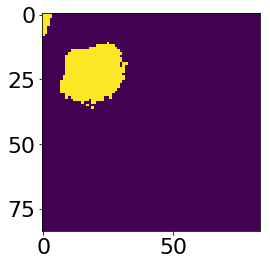

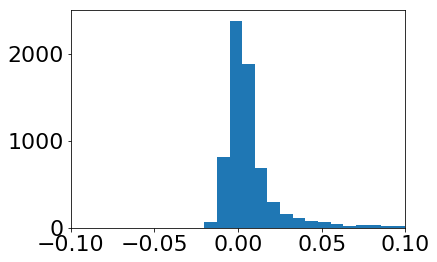

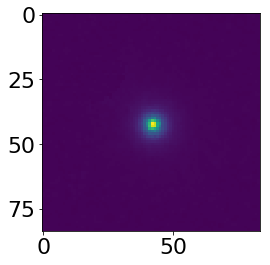

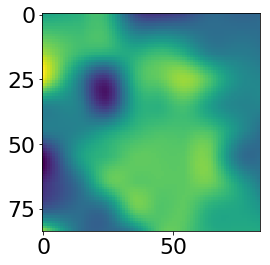

In [121]:
img = _img.copy()
plt.figure()
plt.imshow(np.logical_and(segmap!=0, segmap!=img_id))

src_map = segmap==img_id

noise_bank = img[segmap==0].flatten()
other_source = np.logical_and(segmap!=0, segmap!=img_id)
np.place(img, other_source, noise_bank)

array_sep_likes = img.byteswap().newbyteorder()
bkg = sep.Background(array_sep_likes, mask=segmap==img_id, bw=10, bh=10)
img = img-bkg

print(bkg.globalrms)
plt.figure()
print(img.min(), img.max())
plt.xlim((-0.1, 0.1))
plt.hist(img.flatten(), bins=500)

plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(bkg)

plt.show()

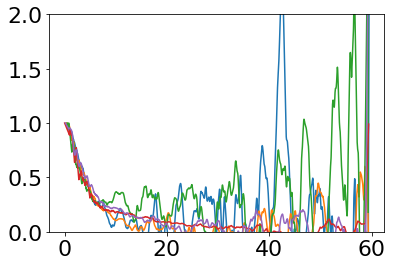

In [126]:
from importlib import reload
reload(dt)

for _img, segmap, img_id in get_random_spheroids(num=5):
    img = denoise(_img, segmap, img_id)

    rs, fs = get_rs_and_fs(img, segmap==img_id)

    _fs = dt.loessc(rs, fs, .60)
    _fs = np.array([_fs[rs==r]/_fs[rs<=r].mean() for r in rs]).flatten()

    plt.ylim((0,2))
    plt.plot(rs, _fs)

plt.show()

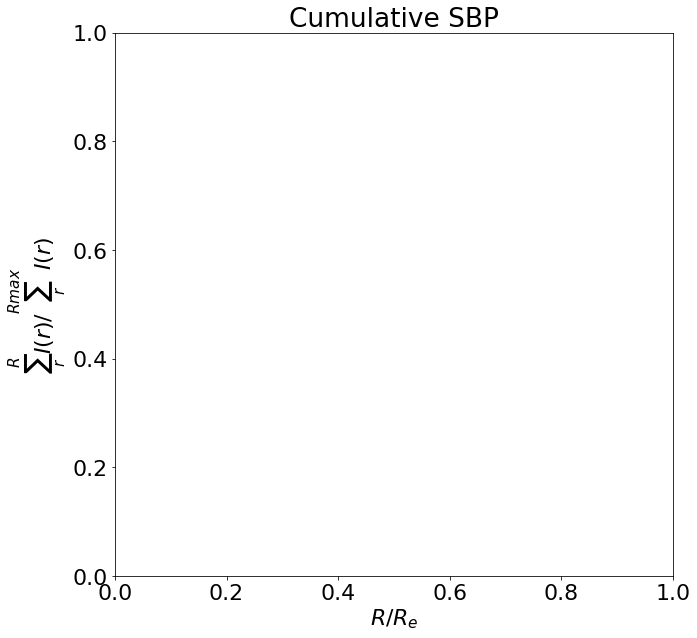

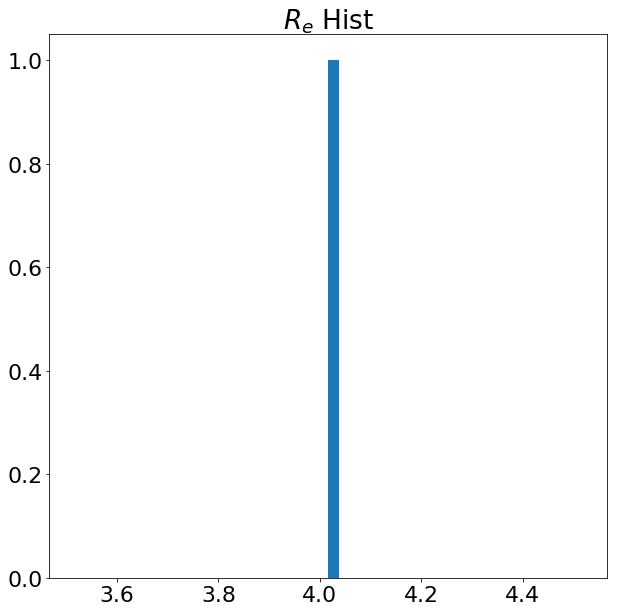

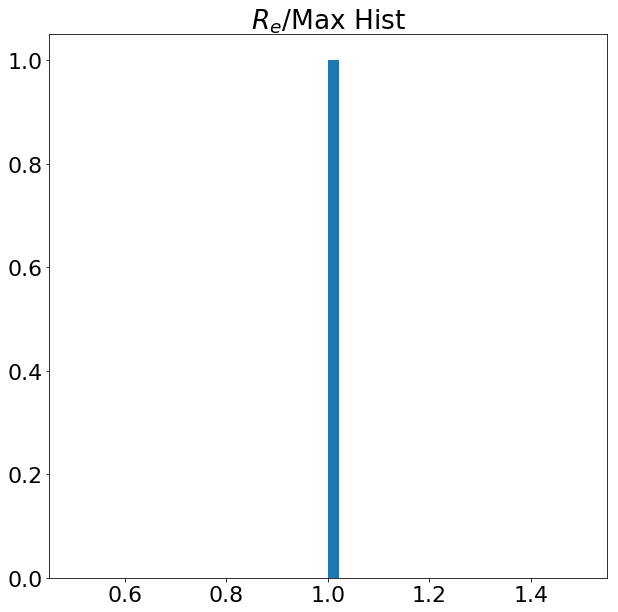

In [9]:
f_size = (10,10)

plt.figure(figsize=f_size)
plt.title('Cumulative SBP')
plt.ylabel('$\sum_r^R I(r) / \sum_r^{Rmax} I(r)$')
plt.xlabel('$R/R_e$')
for r, f in zip(normed_rs, normed_fs):
    color = (e, 0, 0)
    plt.plot(r, np.cumsum(y)/y.sum(), color=color, alpha=0.25)

plt.figure(figsize=f_size)
plt.title('$R_e$ Hist')
plt.hist(res, bins=50)

plt.figure(figsize=f_size)
plt.title('$R_e$/Max Hist')
plt.hist(re_max_ratio, bins=50)


plt.show()